In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to fit LeNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the grayscale images
])

# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=transform)


/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


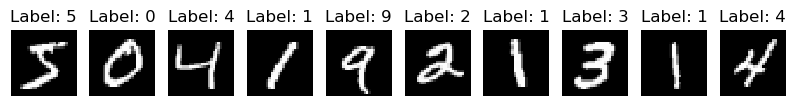

In [2]:
import matplotlib.pyplot as plt

def visualize_samples(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i, ax in enumerate(axes):
        ax.imshow(dataset.data[i].numpy(), cmap='gray', interpolation='none')
        ax.set_title(f'Label: {dataset.targets[i]}')
        ax.axis('off')
    plt.show()

visualize_samples(mnist_trainset)


In [3]:
# Splitting the dataset
train_size = int(0.9 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
mnist_train, mnist_val = random_split(mnist_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32, shuffle=False)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()


Epoch 1 training loss: 0.22210299841779885
Epoch 1 validation loss: 0.07982649461321652
Epoch 2 training loss: 0.06526654831731929
Epoch 2 validation loss: 0.055671232150609984
Epoch 3 training loss: 0.04694190073894711
Epoch 3 validation loss: 0.06445684474013608
Epoch 4 training loss: 0.0368701590555829
Epoch 4 validation loss: 0.07231472639653069
Epoch 5 training loss: 0.03297875357989508
Epoch 5 validation loss: 0.04976844007684664
Epoch 6 training loss: 0.026722724204737203
Epoch 6 validation loss: 0.06319813884808954
Epoch 7 training loss: 0.021572781980634267
Epoch 7 validation loss: 0.05341485500679134
Epoch 8 training loss: 0.01940964216042863
Epoch 8 validation loss: 0.043527350303310064
Epoch 9 training loss: 0.017332991331802123
Epoch 9 validation loss: 0.04666410874052959
Epoch 10 training loss: 0.015289529828649574
Epoch 10 validation loss: 0.043686406556379884
Epoch 11 training loss: 0.014341401018848364
Epoch 11 validation loss: 0.050123879519364506
Epoch 12 training lo

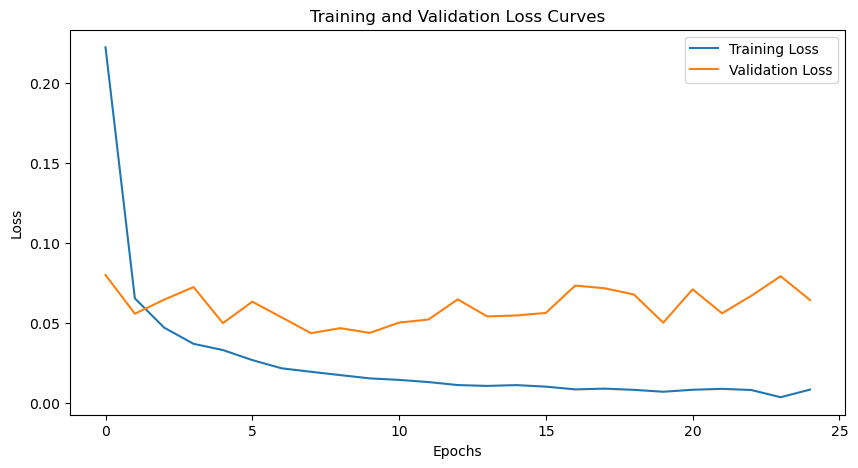

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Initialize lists to track the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(25):  # Adjust the number of epochs as needed
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record training loss
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Record validation loss
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Evaluate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

# Predict on the test set
test_loader = DataLoader(mnist_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  # Print the first 10 predictions


Accuracy of the network on the validation images: 98.86666666666666%
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
